## Train a K-Nearest Neighbors Model
The model will be trained using pandas and scikit-learn.
The model will be trained from data found at https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis

I am running this through VS Code, using a docker container. You may also use the `ipynb` file in other Jupyter Notebook style setups. Consult Jupyter Notebook for options.

**To download the data, run this cell.**

Running this cell will download the data, if you are running it in the docker container. If not, you will need to navigate to the `KAGGLE_DATA_URL` and download the data manually.

In [17]:
import os
from data import download_kaggle_dataset
KAGGLE_DATA_URL = "https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis"
DATA_PATH = os.path.join(os.getcwd(), "data", "knn")
download_kaggle_dataset(KAGGLE_DATA_URL, DATA_PATH)

/workspaces/MS365/src/data/knn contains data. Delete the file(s) if you want to download again.


**Import the necessary python packages**

Import `pandas`, `sklearn.model_selection.train_test_split`, `sklearn.preprocessing.MinMaxScaler`, `sklearn.neighbors.KNeighborsClassifier`, `sklearn.metrics.accuracy_score`, `sklearn.metrics.classification_report`, `imblearn.over_sampling.RandomOverSampler` and `matplotlib.pyplot`. Typically, packages such as `pandas` and `matplotlib.pyplot` are imported with an allias. I will not be following that strategy here. 

The default size of the plots from `matplotlib.pyplot` is 6.4 inches by 4.8 inches ([width by height](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html)). I wll be setting them to 20 inches by 5 inches. This will create a more readable output. Depending on your screen size, you may want to change this for your own use. 

By default, `pandas` will truncate datasets with a lot of rows and a lot of columns. You can alter this functionality with the `set_options()` function. I have set it to show all possible columns. This could result in long run times for cells where you are displaying the data, if there are many columns to display. This will be expected behavior for this analysis.

If you are running the docker container or if you are using [Google Colab](https://colab.research.google.com/), the `pip install` has already been done. If not, then please consult your jupyter notebook environment docs for how to install the needed packages.

In [ ]:
import pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot

matplotlib.pyplot.rcParams['figure.figsize'] = [20, 5]
pandas.set_option('display.max_columns', None)

**Import the data for analysis**

The file used for analysis is `marketing_campaign.csv`. If you used the above cell for downloading the file, the data will be in `/data/knn`. The file is a tab-delimited file, even though it was saved as a .CSV file by the Kaggle user. To load this using pandas, use the `sep=` parameter and specify that the separator will be the tab, which is represented as `\t`.

It is good practice to display the top rows of your dataset to verify that everything imported correctly and to get eyes on what the data are. Use the `head()` method to look at the top 5 rows of data. If you want to see more data, you can use the `n=` parameter and pass in a value. I have used 15, to see the top 15 rows of data.

In [3]:
df = pandas.read_csv(os.path.join(DATA_PATH, "marketing_campaign.csv"), sep="\t")
df.head(n=15)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,09-09-2013,16,520,42,98,0,42,14,2,6,4,10,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,13-11-2012,34,235,65,164,50,49,27,4,7,3,7,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,08-05-2013,32,76,10,56,3,1,23,2,4,0,4,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,06-06-2013,19,14,0,24,3,3,2,1,3,0,2,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,13-03-2014,68,28,0,6,1,1,13,1,1,0,0,20,1,0,0,0,0,0,3,11,0


**Clean the data**

K-Nearest Neighbors (KNN) is a classification algorithm. The premise of KNN is that data can be grouped together based on how similar the data points are to those around it. The similarity of the data points is decided by a distance equation. There are many distance equations to choose from, but the most common to use, and the one that will be used in this analysis, is the Euclidean Distance formula $d = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$ (cosine distance is commonly used in training large language models like ChatGPT). KNN is a non-parametric statistical model and does not hold any assumptions about the data on which it is used. The only requirement of the data is that it is numerical and not categorical.

The data from `marketing_campaign.csv`, shown above, contains a number of categorical data columns that will need to be cleaned before the KNN model can be trained and evaluated. The categorical data could be converted to numerical data through a number of encoding processes, but those methods will not be explored with this model. Instead, the categorical columns will be dropped.

The columns that contain categorical data are `ID`, `Year_Birth`, `Education`, `Marital_Status`, and `Dt_Customer`. Using the [`drop()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) method on the DataFrame will drop the specified columns. Make sure to include the parameter `inplace=True`.

In [4]:
df.drop(columns=["ID", "Year_Birth", "Education", "Marital_Status", "Dt_Customer"], inplace=True)

The specific data types in your DataFrame `df` need to be numerical. Run the `dtypes` attribute on `df` to verify that all remaining columns are numeric data types. The numeric data type options are `int` and `float`. You may also see `int64` and `float64`, which fall in the `int` and `float` data types.

In [5]:
df.dtypes

Income                 float64
Kidhome                  int64
Teenhome                 int64
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

Run the `describe()` method on `df` to verify that there are not any missing values in the many columns. 

Most columns show 2,240 rows of data. The `Income` column shows 2,216 rows of data. The count is the number of non-null values. Since there are only 2,216 rows of non-null values in the `Income` column, it will be necessary to fill those values with a value. A common strategy is to use the median, mean, or mode to fill in missing data. This provides data for every row without altering the statistics of the column too much.

Looking at the output for `describe()`, the mean and the median are displayed. The median is the value at the 50% or 50th percentile. Those two values are very similar to each other, so using the mean or the median could be a good strategy for filling in the missing values. It is possible that there is a better method for filling in the missing data, but that will not be explored at this time.

In [6]:
df.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


Fill in the missing values in the `Income` column with the mean of the column. Use [`fillna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html) with the mean of `df.Income` for the value and `inplace=True`. Rerunning `df.describe()` will show that all columns now have the same number of counts.

In [7]:
df.fillna(value=df.Income.mean(), inplace=True)
df.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,25037.797168,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,35538.750000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,51741.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,68289.750000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


**Create and Train K-Nearest Neighbors model**

KNN is a statistical model that learns as you feed it more data. The thing that we want the model to learn is the `Response` value, based on all the other columns in the dataset. The `Response` column will be our dependent variable, and it will be labeled as `y_column`. The rest of the columns in the dataset will be the independent variables and will be labeled as `x_columns`. The variable `x_columns` is a list of the column names; using the `columns` attribute will provide that information. Using the `remove` function on the `x_columns` variable will remove the `y_column` value from the list.

Once the values for the columns has been created, use those values to split `df` into two separate variables. Use `x_columns` to create `x_data` and use `y_column` to create `y_data`. This will be the data used to train the KNN model.

In [8]:
y_column = "Response"
x_columns = list(df.columns)
x_columns.remove(y_column)

x_data = df[x_columns]
y_data = df[y_column]

**Normalize the Data**

KNN is non-parametric and makes no assumptions about the data. However, it does require numerical data and there will be the assumption that the data follows typical numerical characteristics. Thus, larger numbers are given more weight than smaller numbers. Because of this, our data will likely cause problems for the KNN model because the data are not on the same scale in every column. Reviewing the MAX and MIN values in the `describe` table above will show a lot of variation in those numbers. To account for this, the data should be normalized, fitting it to a specific range scale.

Scikit-learn provdes the method [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) that can be used to normalize the data. `MinMaxScaler` uses a default range of 0-1 for normalization. This is the scale that will be used.

Create a variable called `min_max_scale`, which will represent an instance of `MinMaxScaler()`. Pass in the `x_data` variable to the `fit_transform()` method, using `min_max_scale.fit_transform(x_data)`. This will return a data set that has been normalized, where all values will be on a scale from 0 to 1 (the default scale for `MinMaxScaler`). If you were to look at the data output from `MinMaxScaler`, you would see a list of lists of values. That represents the scaled version of the data. Convert it to a dataframe by passing in the `normalized_x` variable to `pandas.DataFrame()`, and specifying the columns as `x_data.columns`. The output of that will be a dataframe. I have assigned the output from `min_max_scale.fit_transform` to `normalized_x` and then I have overwritten `normalized_x` by saving the output of the dataframe to `normalized_x`. This results in a dataframe in `normalized_x` that can be used to train the KNN model.

In [9]:
min_max_scale = MinMaxScaler()
normalized_x = min_max_scale.fit_transform(x_data)
normalized_x = pandas.DataFrame(normalized_x, columns=x_data.columns)

**Split data into training and testing datasets**

The data will need to be split into training datasets and testing datasets. The function `train_test_split` imported from `sklearn.model_selection` can be used to split the data. The function will take the `x_data` and `y_data` and split it into similarly sized datasets. You should consult the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to get a better understanding of the different parameters that can be passed in.

Create variables `x_train`, `x_test`, `y_train`, and `y_test`. The function `train_test_split` will ouput the data to these 4 variables because we used the `x_data` first and the `y_data` second in the parameters of the function.

Some key things to keep in mind:
1. `train_test_split` will split the data randomly. You should set a seed value for the `random_state` parameter so the random separation is consistent. I have chosen `22`.
2. The order you use for your `y_data` and your `x_data` will effect the output data. If you do `train_test_split(y_data, x_data)`, then your output will be y_data before x_data. If you do `train_test_split(x_data, y_data)`, the x_data will be before the y_data.
3. A fairly standard choice for the size of your test data is 20% of the total data. If you have more data, you may be able to do a smaller percentage. (more meaning millions of rows of data, or more)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(normalized_x, y_data, test_size=0.20, random_state=22)

**Create a K-Nearest Neighbors model**

Use [`KNeighborsClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to create a KNN model. KNN requires a value for the number of "neighbors" to create. The default value in the Sci-kit learn model is 5. A general [rule of thumb](https://mmuratarat.github.io/2019-07-12/k-nn-from-scratch#:~:text=K%2DNN%20algorithm%20is%20an,samples%20in%20the%20training%20dataset.) for the KNN model is to use the square-root of the number of values that are in your dataset ($\sqrt n$). This would be considered a starting point for training the model and not necessarily the best number of neighbors for the model. The process for finding the best number for neighbors is an iterative process and can require many values before the best one is found. It is also best to use odd numbers for your neighbors value. This avoids instances where there could be a tie between the output of the distance values.

The dataset contains 2,240 rows of data. The square-root of 2,240 is approximately 47. For this first iteration, I will use 47 as the number of neighbors. It is likely not the best option, but this will be an iterative process, where the best value for the number of neighbors is determined through testing.

The variable `knn` has been created using `KNeighborsClassifier(n_neighbors=k_neighbors).fit(x_train, y_train)`. Chaining the `fit()` method to the creation of the model will result in a trained model.

Create a `y_estimates` variable using the `predict()` method. The `y_estimates` variable will be the values predicted by the trained model. 

*`k_neighbors` will be used many times below, so I have created this here, to reuse later.*

In [11]:
k_neighbors = 47
knn = KNeighborsClassifier(n_neighbors=k_neighbors).fit(x_train, y_train)
y_estimates = knn.predict(x_test)


**Verify the accuracy of the model.**

Scikit-learn provides [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) and [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) from `sklearn.metrics` for verifying the accuracy of the model. 

Run a `print()` statement around `accuracy_score()` to print the percentage of correctly classified samples. The `accuracy_score` method expects the correct values and the estimated values for your first two parameters. There are other parameters as well, but the default values will be used for this verification. The returning value is ~0.8616, which suggests that our trained model was approximately 86% correct at choosing the correct label. This is a good number. The rule of thumb for an accuracy score is that it be as close to 1.0 as possible, without being 1.0. 86% is likely a very strong value for this model.

The second accuracy verification process is `classification_report()`. Pass in the true values and the estimated values to receive a more in depth analysis of the model. The output shows the precision, recall, f1-score, and support for the identified classes: 0 and 1. The following will help to better understand the output and how to interpret it.
* Precision: percentage of true-positive lables
* Recall: percentage of correctly identified true-positives
* F1-Score: calculation of precision and recall, the closer to 1.0, the better
* Support: how many examples belong to each class

The F1-Score will be the value that is the most interesting for this analysis. It shows .92 for 0 and .34 for 1. This means that the model is very good a picking 1, but not very good at picking 0. The reason for this is likely due to the value in Support. Support shows that there are more 0 values than 1 values, showing that the data are skewed in such a way to provide more examples of 0 than 1.

In [12]:
print("Accuracy Score: ", accuracy_score(y_test, y_estimates), "\n")
print(classification_report(y_test, y_estimates))

Accuracy Score:  0.8616071428571429 

              precision    recall  f1-score   support

           0       0.87      0.99      0.92       375
           1       0.76      0.22      0.34        73

    accuracy                           0.86       448
   macro avg       0.81      0.60      0.63       448
weighted avg       0.85      0.86      0.83       448



**Issues with the KNN model**

As mentioned above, there are a couple issues that need to be addressed for this KNN model. The first is that it is possible that 47 is not the correct value for the number of neighbors that need to be used. The second issue is that there are more 0 values in `Response` than there are 1 values. Both of these issues can be addressed relatively easily.

To address the unbalanced data issue, use [`RandomOverSampler`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html) from `imblearn.over_sampling`. `RandomOverSampler` oversamples the minority class by picking samples at random, and then replacing those values back in the population, allowing them to be resampled. In essence, it creates duplicates of the minority class, at random, creating enough records to match the majority value. For our use, this will increase the number of 1 values to equal that of the 0 values.

Create a `RandomOverSampler` model with a `random_state` parameter equal to 17. Here, it has been assigned to the variable `over_sampler`. Use the `over_sampler` variable to `fit_resample()` the `normalized_x` data and the `y_data`. The output has been saved in the variables `x_over` and `y_over`, in that order.

In [13]:
over_sampler = RandomOverSampler(random_state=17)
x_over, y_over = over_sampler.fit_resample(normalized_x, y_data)

The steps for training a new KNN model are the same as were presented above. The difference is now the model will be trained on the `x_over` and `y_over` data. Below, everying that has to do with the oversampled data is labled with `over` to distinguish it from the data used above. The oversampling created more records, as shown in the output of the `classification_report` table, where support now shows 374 values that are 0 and 389 values that are 1. However, the oversampling seems to have worsened the model's effectiveness, based on the Accuracy Score of 0.7824. The f-1 scores show that the model has worsened in predicting 0 values and improved in predicting 1 values, where both are at 78%.

This may be a more accurate model even though the accuracy value went down, but since oversampling was used, and the data were copied, it is difficult to know if that is the case. The python package `imblearn` has other methods for sampling data. It may be the case that another method of sampling may provide better results. However, some of the other methods for oversampling have to do with creating synthetic data. This is almost always a bad strategy. There is a lot of literature on why this typically doesn't work. A quick Google search should assist you if this is something that would be of interest. Also, since there are only 2,240 data points, it is possible that there are not enough to get a good analysis. A better analysis may need 100s of thousands of records, or more.

In [14]:
x_over_train, x_over_test, y_over_train, y_over_test = train_test_split(x_over, y_over, test_size=0.20, random_state=22)
over_knn = KNeighborsClassifier(n_neighbors=k_neighbors).fit(x_over_train, y_over_train)
y_over_estimates = over_knn.predict(x_over_test)
print("Accuracy Score: ", accuracy_score(y_over_test, y_over_estimates), "\n")
print(classification_report(y_over_test, y_over_estimates))

Accuracy Score:  0.7824377457404981 

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       374
           1       0.80      0.76      0.78       389

    accuracy                           0.78       763
   macro avg       0.78      0.78      0.78       763
weighted avg       0.78      0.78      0.78       763



In addition to the square-root method mentioned above ($\sqrt n$) for selecting the number of K, it is also common to plot out a series of accuracy scores and look for the place where the plot drastically changes, or forms an [elbow](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/). The process seems simple. Train many models, comparing the accuracy score, and when the amount of change levels out, that is likely the best number of neighbors for the model.

This can be done by creating a for-loop, and looping through the model creation process, saving the accuracy score from each trained model. Create a list called `results`. Create a for-loop, looping through the values you want for K. This can be done by using the python-built-in method [`range()`](https://docs.python.org/3/library/functions.html#func-range). The range function can take 3 parameters: start, stop, and step. Typically, step is defaulted to 1 and the function will create a list of values from start to end, steping by 1. Using -1, will mean that the function will step -1 from the start value. Looping through the `range()` values below, will provide a list from 47 to 2, stepping down one value each pass. The rest of the for-loop should look familiar. Create a `KNeighborsClassifier` and train it using the value `k` from the for-loop. The the value of K and the accuracy score to the `results` list as a dictionary value. Pass the `results` list of dictionaries into `pandas.DataFrame` to create a dataframe with the rows and columns of the trained models accuracy score.

*I multiplied the accuracy score by 100 to get the average in whole numbers.*

Running `results_df` as the final line in this cell will show the values in the `results_df` dataframe, starting with 47 at the top, and ending with 2 at the bottom.

In [15]:
results = []
for k in range(k_neighbors, 1, -1):
    looped_knn = KNeighborsClassifier(n_neighbors=k).fit(x_over_train, y_over_train)
    results.append(
        {
            'k': k,
            'accuracy': accuracy_score(y_over_test, looped_knn.predict(x_over_test)) * 100
        }
    )
results_df = pandas.DataFrame(results)
results_df

,k,accuracy
0,47,78.243775
1,46,77.588467
2,45,77.850590
3,44,78.112713
4,43,78.243775
5,42,78.636959
6,41,79.816514
7,40,79.554391
8,39,79.685452
9,38,80.340760


Use the values in `results_df` to create a scatter plot, using the built in `plot.scatter` method from `pandas`. Use `matplotlib.pyplot` to provide the necessary labels. Adding `xticks` will make the x-axis easier to read.

The graph shows the accuracy scores for each of the trained models. It levels out at 10 or 11 neighbors. This means that 11 is likely the best choice for the number of neighbors, providing an accuracy rate of approximately 80%.

One last thought on this model, since the `Response` values are binary in nature, it is likely that 2 neighbors is all that is wanted. This would strictly divide the data based on the 2 possible outcomes, which would improve the accuracy of the trained model to ~94%. However, it is also likely that with only 2 neighbors, the data would be over-fitted to the model, and any new data would not be easily identified. It also means that there would be issues with any tie-breaking that needed to occur, when assigning new values to the correct group. It is also likely that the K-Nearest Neighbors model is not a good choice for these kinds of data.

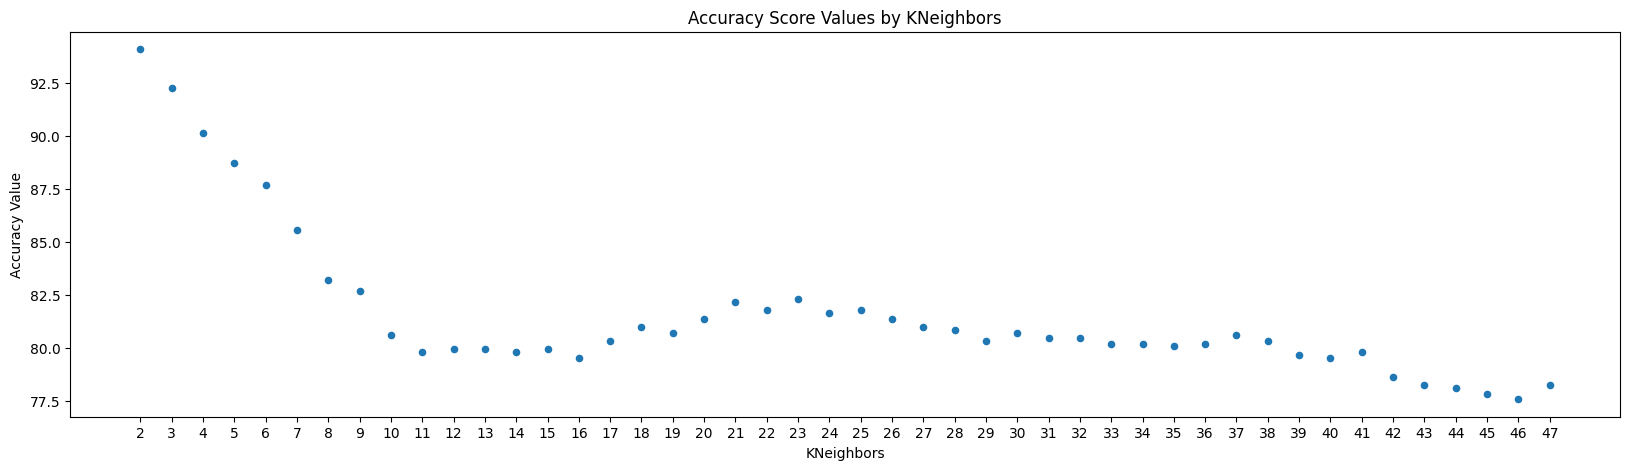

In [16]:
k_start = results_df.k.min()
k_end = results_df.k.max() + 1
results_df.plot.scatter(x="k", y="accuracy")
matplotlib.pyplot.title("Accuracy Score Values by KNeighbors")
matplotlib.pyplot.xlabel("KNeighbors")
matplotlib.pyplot.ylabel("Accuracy Value")
matplotlib.pyplot.xticks(range(k_start, k_end))
matplotlib.pyplot.show()